# Using Electronic Lab Notebook information for analysis

In this notebook we will demonstrate a simple use case of using queried NEXUS data to download files from XNAT.

XNAT Instance: https://xnat-curate.ae.mpg.de

XNAT Projects loaded: "NEXUS ECOG, NEXUS FMRI, NEXUS ECOG"

Steps:
1. Load data from xnat -> postgres -> nexus
2. Pick a simple query based on existing forms
3. Construct the query, and run it
4. Expose the result for further use.

## Query
- "Powerline Frequency" 50
- "Race" Asian
- "Eye Dominance" Right
- "Institute" University of Birmingham

Query 3 output parameters required
- project, subject, session

expected: nexus1, NA002, NA002_MEEG_1

In [1]:
import os.path as op

import matplotlib.pyplot as plt

import xnat
import requests

import mne
from mne.viz import snapshot_brain_montage, plot_bridged_electrodes
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_sensors_connectivity

import pydicom
from pprint import pprint

mne.set_log_level('ERROR')

# set the XNAT hostname
xnat_host = 'xnat-curate'

NEXUS Queries are shown in the other sample notebooks.

In [2]:
# Expected results of Query 3 - nexus1, NA002, NA002_MEEG_1
project_name = "nexus1"
subject_name = "NA002"
session_name = "NA002_MEEG_1"
scan_name = "RestingEO"
download_dir = "/Users/praveen.sripad/Downloads/2023-08-10_eln_demo"
downloaded_file = op.join(download_dir, 
                          "NA002_MEEG_1/scans/RestingEO-RestingEO/resources/FIF/files/NA002_MEEG_V1_RestingEO.fif")


In [3]:
if not op.isfile(downloaded_file):
    # start connection to XNAT
    with xnat.connect('https://%s.ae.mpg.de' % xnat_host,
                      netrc_file=op.join(op.expanduser('~'), '.%s_netrc' %
                      xnat_host.replace('-', '_')), loglevel='ERROR') as connection:
        # download the data
        connection.projects[project_name].subjects[subject_name].experiments[session_name].scans[scan_name].download_dir(download_dir)

assert op.isfile(downloaded_file), 'File not available.'

# Load and use the downloaded data

In [4]:
raw = mne.io.Raw(downloaded_file, preload=True)

In [10]:
raw.plot();

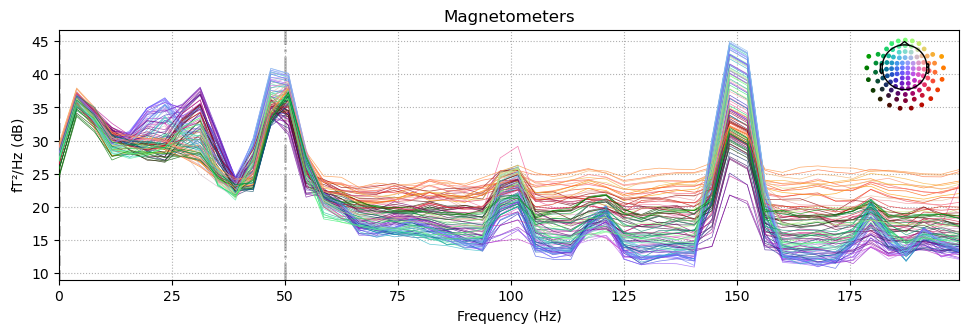

In [5]:
raw.compute_psd(fmin=0., fmax=200., picks=['mag']).plot(show=False);

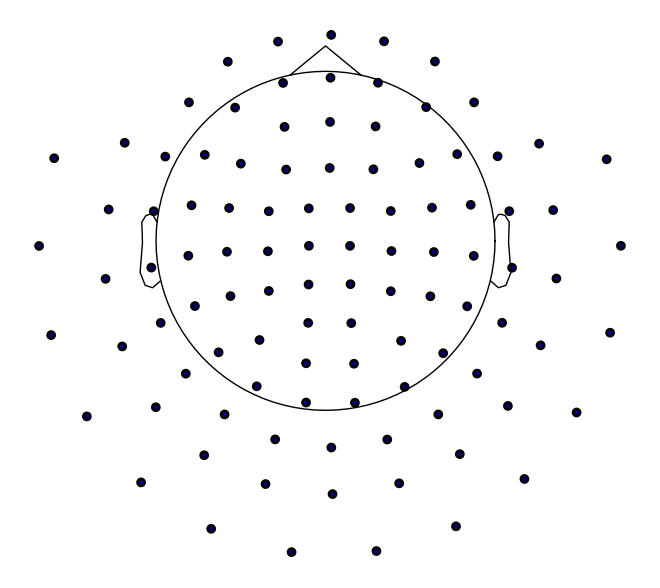

In [6]:
raw.plot_sensors(kind='topomap');

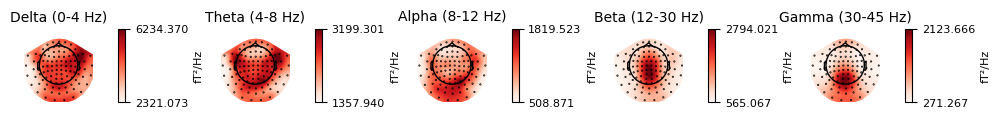

In [7]:
raw.plot_psd_topomap();

In [8]:
epochs = mne.make_fixed_length_epochs(raw, duration=5.0, 
                                      preload=True, reject_by_annotation=True,
                                      proj=True, overlap=0.0, id=1)

# Compute connectivity for band containing the evoked response.
# We exclude the baseline period:
fmin, fmax = 4., 9.
sfreq = raw.info['sfreq']  # the sampling frequency
tmin = 0.0  # exclude the baseline period
epochs.load_data().pick_types(meg='grad')  # just keep MEG and no EOG now
con = spectral_connectivity_epochs(
    epochs, method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)


In [11]:
# Now, visualize the connectivity in 3D:
fig = plot_sensors_connectivity(
          epochs.info,
          con.get_data(output='dense')[:, :, 0])

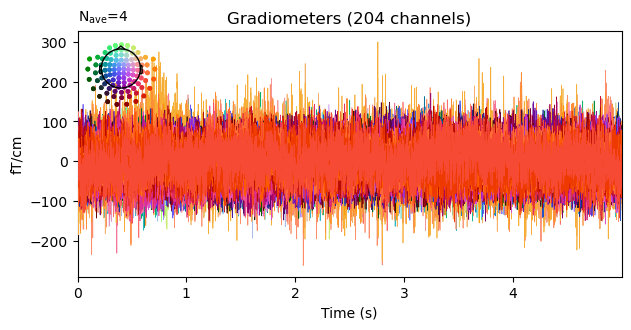

In [9]:
epochs.average().plot();

## Plot sensor sensitivity across the brain surface

In [12]:
subjects_dir = '/Users/praveen.sripad/nanna_data/mne_data/MNE-sample-data/subjects'
fname_fwd = '/Users/praveen.sripad/nanna_data/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'

fwd = mne.read_forward_solution(fname_fwd)

mne.convert_forward_solution(fwd, surf_ori=True, copy=False)
leadfield = fwd["sol"]["data"]
print("Leadfield size : %d x %d" % leadfield.shape)

grad_map = mne.sensitivity_map(fwd, ch_type="grad", mode="fixed")
mag_map = mne.sensitivity_map(fwd, ch_type="mag", mode="fixed")

picks_meg = mne.pick_types(fwd["info"], meg=True, eeg=False)

brain_sens = grad_map.plot(
    subjects_dir=subjects_dir, clim=dict(lims=[0, 50, 100]), figure=1
)
brain_sens.add_text(0.1, 0.9, "Gradiometer sensitivity", "title", font_size=12)

Leadfield size : 306 x 22494


qt.qpa.fonts: Populating font family aliases took 56 ms. Replace uses of missing font family "Menlo" with one that exists to avoid this cost. 


do further analysis... 

## Put back analysis information back into the ELN

In [ ]:
headers = {'content-type': 'application/json', 'accept': 'application/json'}

uri = '/xapi/custom-fields/projects/%s/subjects/%s/experiments/%s/fields'\
        % (project_name, subject_name, session_name)

data={'6c6903c7-5c0a-4042-b6c6-a40c616fdd41':
        {'analysis_steps': 'load_data, filtering, time_frequency_analysis',
         'analysis_order': 'load_data, filtering, time_frequency_analysis'}}


In [ ]:
# start connection to XNAT
with xnat.connect('https://%s.ae.mpg.de' % xnat_host,
                  netrc_file=op.join(op.expanduser('~'), '.%s_netrc' %
                  xnat_host.replace('-', '_')), loglevel='ERROR') as connection:    
    # upload the new data onto the analysis form
    status = connection.put(uri, json=data, headers=headers)
    # get the updated data and show it
    pprint(connection.get_json(uri))
    print('Status code:', status)

END.